In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
import re
from FRVRS import nu
import matplotlib.pyplot as plt
import re


# OSU dataset of Simulation Sessions, deidentified

Doug screened all of the **VOICE_COMMAND** and **VOICE_CAPTURE** lines and replaced any names with either Max or Jane, regardless of whether the name was that of the responder.

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(149166, 101)


,16222,14144,13548,29939
action_type,INJURY_RECORD,TOOL_HOVER,VOICE_CAPTURE,PATIENT_ENGAGED
action_tick,3696777,2258210,1889075,432406
event_time,2023-05-16 17:16:00,2023-05-16 16:52:00,2023-05-16 16:46:00,2023-03-07 10:23:00
session_uuid,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,33e7d6b6-2868-42e6-8967-d6890efb87a7
file_name,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,724fdf45-3165-43b8-b9ca-dc07102d2886,Marty11
scene_id,10,7,6,2
injury_record_id,L Thigh Laceration,NaN,NaN,NaN
injury_record_patient_id,Mike_1 Root,NaN,NaN,NaN
injury_record_required_procedure,tourniquet,NaN,NaN,NaN
injury_record_severity,medium,NaN,NaN,NaN



## Decision Points

<p>
    OSU and Big Bear: With the IRB approval (for the previous OSU dataset) in place, I would like to get working on the dataset asap. That means:
    <ul>
        <li>Getting it deidentified and sharable</li>
        <li>If there is general demographic information like gender or level of expertise that can be associated with the VR performance, that would be useful.</li>
        <li>Big Bear: once it is available to you, I want an exploratory analysis on decision points such that I can see the variance in responses to the same situation.</li>
        <li>For example, if there are 3 waving patients and the participant chooses to move toward one and assess them, I want to know the sim state (visual info. on each patient, distance, etc.) and then a breakdown of how many participants chose to move toward each patient.</li>
        <li>Similar for treatment options, for each patient present in the simulated environment, what is the variance in which treatment is applied</li>
         <li>Does it depend on ordr?</li>
          <li>Ting?</li>
           <li>Be creative and ask all the questions. The goal is to provide TA1 with this dataset if there is anything useful to be found in analyzing the decisions (not necessarily that we find results but that the data is in shape to ask these questions). Let me know if you need additional clarifiion   </l    i>
</</p>
ion.

In [4]:

# List the action types
frvrs_logs_df.action_type.value_counts().sort_index()

action_type
BAG_ACCESS              2180
BAG_CLOSED              2149
INJURY_RECORD           3052
INJURY_TREATED          1577
PATIENT_DEMOTED         1818
PATIENT_ENGAGED         2295
PATIENT_RECORD          2063
PULSE_TAKEN             3427
SESSION_END              256
SESSION_START            266
S_A_L_T_WALKED          2725
S_A_L_T_WALK_IF_CAN     4567
S_A_L_T_WAVED           1761
S_A_L_T_WAVE_IF_CAN     2147
TAG_APPLIED             1819
TAG_DISCARDED            533
TAG_SELECTED            2353
TELEPORT                5678
TOOL_APPLIED            1818
TOOL_DISCARDED          1655
TOOL_HOVER             89733
TOOL_SELECTED           2263
VOICE_CAPTURE          10115
VOICE_COMMAND           2916
Name: count, dtype: int64

In [7]:

# Store a dataset of DM actions as a CSV
if not nu.pickle_exists('patient_engagement_timeline_df'):
    columns_list = [
        'session_uuid', 'action_type', 'action_tick', 'event_time', 'tag_applied_type', 'tool_applied_type', 'injury_treated_id',
        'patient_id', 'location_id', 'scene_id'
    ]
    patient_engagement_timeline_df = pd.DataFrame()
    for session_uuid, session_df in fu.get_session_groupby(frvrs_logs_df):
        mask_series = session_df.action_type.isin(['SESSION_END', 'SESSION_START'])
        patient_engagement_timeline_df = pd.concat(
            [patient_engagement_timeline_df, session_df[mask_series][columns_list].dropna(axis='columns', how='all')], axis='index'
        )
        mask_series = frvrs_logs_df.action_type.isin([
            'INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
        ])
        for patient_id, patient_df in session_df[mask_series][columns_list].groupby('patient_id'):
            patient_engagement_timeline_df = pd.concat(
                [patient_engagement_timeline_df, patient_df.dropna(axis='columns', how='all')], axis='index'
            )
    patient_engagement_timeline_df = patient_engagement_timeline_df.sort_values(['session_uuid', 'event_time', 'action_tick'])
    nu.save_data_frames(patient_engagement_timeline_df=patient_engagement_timeline_df)

Saving to C:\Users\DaveBabbitt\Documents\GitHub\notebooks\saves\csv\patient_engagement_timeline_df.csv


In [8]:

frvrs_logs_df.loc[51217].dropna(axis='index', how='all').to_frame()

,51217
action_type,TAG_APPLIED
action_tick,281683
event_time,2023-06-07 10:30:00
session_uuid,04882754-51a0-4e5b-9617-b200e3609116
file_name,04882754-51a0-4e5b-9617-b200e3609116
scene_id,2
tag_applied_patient_id,Gary_3 Root
tag_applied_type,red
patient_id,Gary_3 Root
delta_to_next_action,0 days 00:00:02.925000



### Patient Engagement


These action types mean that the DM has made a decision: INJURY_TREATED, PATIENT_ENGAGED, PULSE_TAKEN, TAG_APPLIED, and TOOL_APPLIED.


#### Record the decision points on each patient's timeline in a Patient Engagement timeline CSV

In [9]:

mask_series = frvrs_logs_df.action_type.isin(['PATIENT_ENGAGED'])
# columns_list = frvrs_logs_df[mask_series].dropna(axis='columns', how='all').columns.tolist()
columns_list = [
    'action_tick', 'patient_engaged_health_level', 'patient_engaged_health_time_remaining', 'patient_engaged_id',
    'patient_engaged_position', 'patient_engaged_rotation', 'patient_engaged_salt', 'patient_engaged_sort', 'patient_engaged_pulse',
    'patient_engaged_breath', 'patient_engaged_hearing', 'patient_engaged_mood', 'patient_engaged_pose'
]
frvrs_logs_df[mask_series][columns_list].sample(4).T

,32644,77077,39140,117085
action_tick,180420,229300,447317,565928
patient_engaged_health_level,100,100,100,100
patient_engaged_health_time_remaining,Infinity,Infinity,0,Infinity
patient_engaged_id,Mike_1 Root,Mike_2 Root,Gary_3 Root,Mike_7 Root
patient_engaged_position,"(2.9, 0.0, 0.1)","(4.3, 0.0, -4.5)","(0.4, 0.0, 1.7)","(1.3, 0.0, 3.4)"
patient_engaged_rotation,"(0.0, 0.7, 0.0, -0.7)","(0.0, 0.1, 0.0, -1.0)","(0.0, 0.0, 0.0, 1.0)","(0.0, 0.1, 0.0, 1.0)"
patient_engaged_salt,DELAYED,IMMEDIATE,IMMEDIATE,DELAYED
patient_engaged_sort,waver,walker,still,waver
patient_engaged_pulse,normal,fast,faint,fast
patient_engaged_breath,normal,normal,collapsedRight,normal



#### Visualize the decision points on each patient's timeline

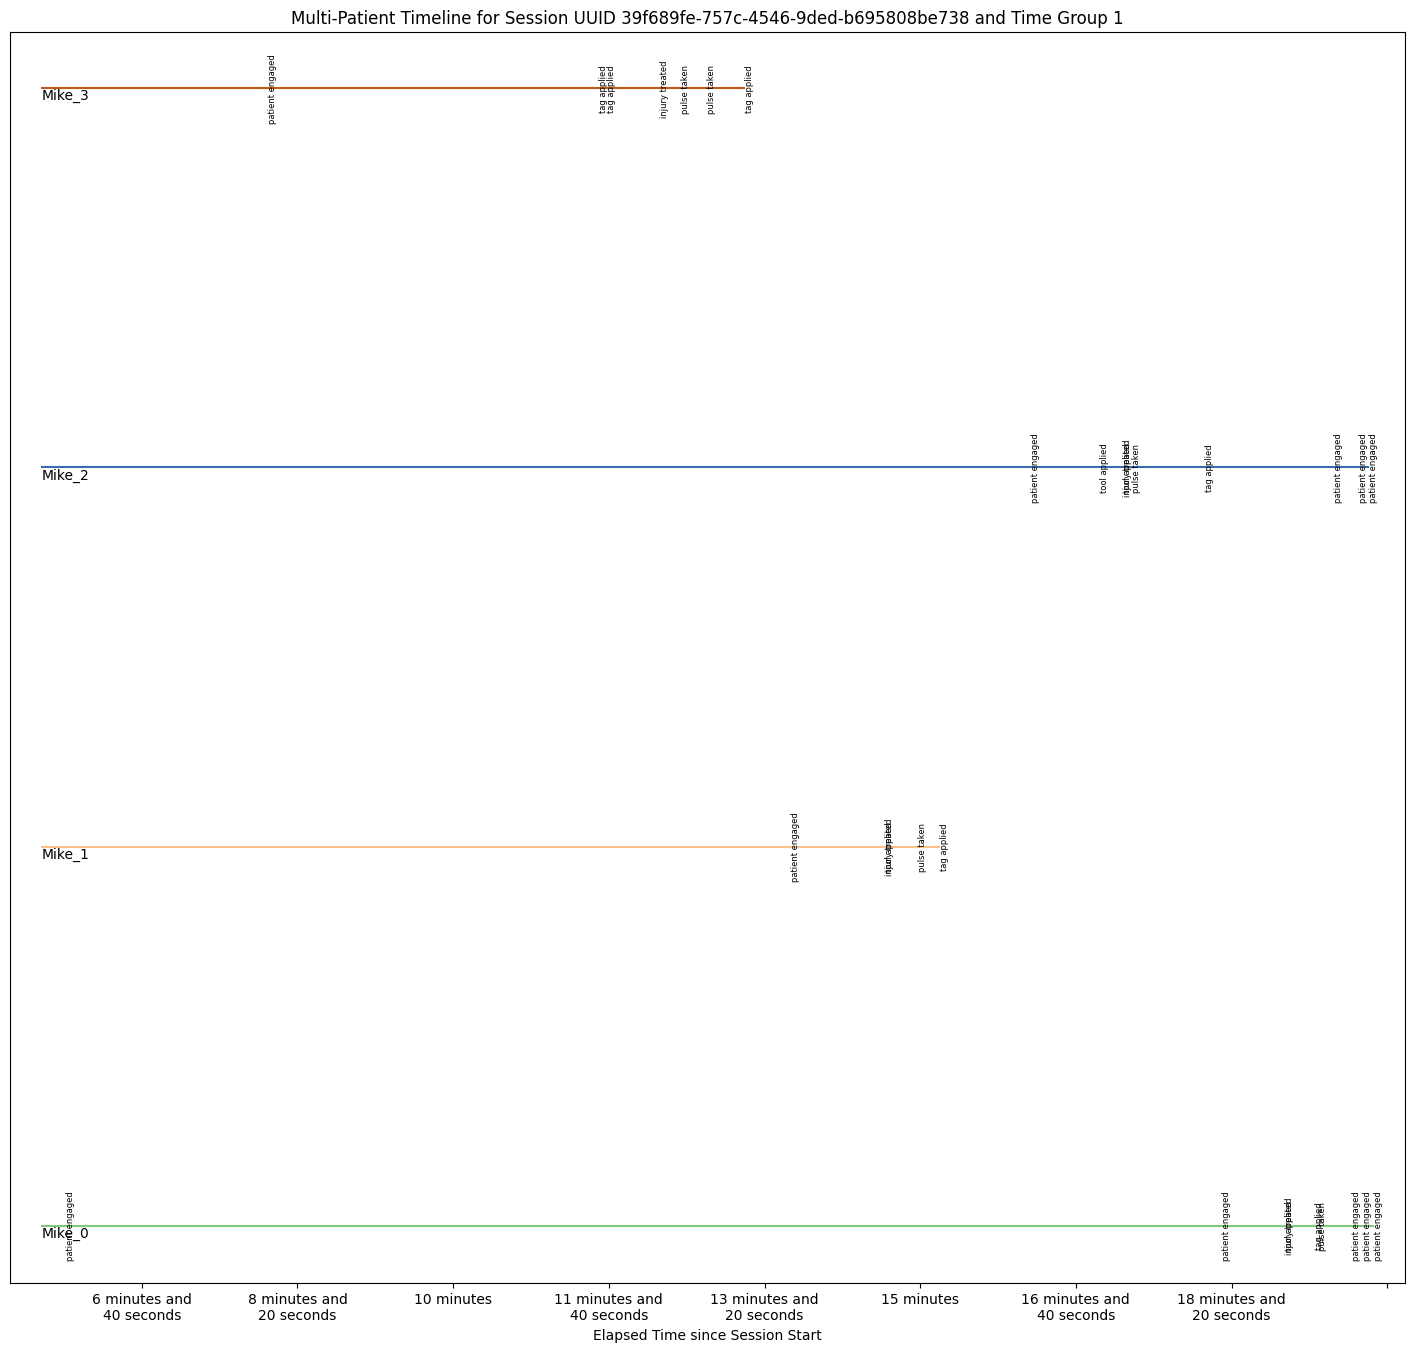

In [19]:

random_session_uuid, random_time_group, gary_df = fu.show_timelines(frvrs_logs_df)


When the *PATIENT_DEMOTED* type action happens, it means only that the status of a patient has changed. This happens when the scene first loads and the initial patient status is calculated. Over time, if the patient is not attended to, the status will degrade and the PATIENT_DEMOTED metric is issued.

In [193]:

# Display the captured timeline (Gary_3's)
mask_series = gary_df.action_type.isin([
    'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
])
action_tick = fu.get_scene_start(gary_df[mask_series])
event_time = gary_df[mask_series].event_time.min()
mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_id == random_time_group)
mask_series &= (frvrs_logs_df.action_tick <= action_tick) & (frvrs_logs_df.event_time <= event_time)
columns_list = [
    'action_type', 'action_tick', 'event_time', 'voice_capture_message', 'voice_command_message', 'patient_demoted_salt',
    'patient_id', 'location_id'
]
display(frvrs_logs_df[mask_series][columns_list].head(20).dropna(axis='columns', how='all'))

,action_type,action_tick,event_time,voice_capture_message,patient_demoted_salt,patient_id,location_id
138481,TELEPORT,2372,2023-04-21 10:06:00,NaN,NaN,NaN,"(2.4, 0.0, 2.1)"
138482,VOICE_CAPTURE,4261,2023-04-21 10:06:00,Yeah,NaN,NaN,NaN
138483,TELEPORT,4895,2023-04-21 10:06:00,NaN,NaN,NaN,"(2.0, 0.0, 1.7)"
138484,VOICE_CAPTURE,6599,2023-04-21 10:06:00,yeah,NaN,NaN,NaN
138485,VOICE_CAPTURE,9455,2023-04-21 10:06:00,so it turns green OK,NaN,NaN,NaN
138486,VOICE_CAPTURE,13213,2023-04-21 10:06:00,well put it like teleport yeah,NaN,NaN,NaN
138487,VOICE_CAPTURE,21616,2023-04-21 10:07:00,right here,NaN,NaN,NaN
138488,BAG_ACCESS,24023,2023-04-21 10:07:00,NaN,NaN,NaN,"(3.1, 0.8, 10.6)"
138489,VOICE_CAPTURE,25257,2023-04-21 10:07:00,index finger on the trigger,NaN,NaN,NaN
138490,VOICE_CAPTURE,28384,2023-04-21 10:07:00,oh right here,NaN,NaN,NaN



### Affinity Analysis and Association Rule Learning using the Apriori Algorithm

In [4]:

# Record as transactions a more complex example of a patient engagement
if nu.pickle_exists('patient_engagement_transactions'):
    patient_engagement_transactions = nu.load_object('patient_engagement_transactions')
else:
    patient_engagement_transactions = []
    mask_series = (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
    for (session_uuid, patient_id), patient_df in fu.get_session_groupby(
        frvrs_logs_df, mask_series=mask_series, extra_column='patient_id'
    ):
        for scene_id, scene_df in patient_df.groupby('scene_id'):
            mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id)
            action_tick = fu.get_scene_start(scene_df); mask_series &= (frvrs_logs_df.action_tick <= action_tick)
            event_time = scene_df.event_time.min(); mask_series &= (frvrs_logs_df.event_time <= event_time)
            action_types_list = frvrs_logs_df[mask_series].tail(20).action_type.tolist()
            patient_engagement_transactions.append(action_types_list)
    nu.store_objects(patient_engagement_transactions=patient_engagement_transactions)

In [49]:

from apyori import apriori

apyori_rules_generator = apriori(
    patient_engagement_transactions, min_support=0.0022, min_confidence=0.20, min_lift=3, min_length = 4
)

# Store rules in result variable
if nu.pickle_exists('apyori_rules_list'):
    apyori_rules_list = nu.load_object('apyori_rules_list')
else:
    apyori_rules_list = list(apyori_rules_generator)
    nu.store_objects(apyori_rules_list=apyori_rules_list)

# See the items that were bought together with their support
results_list = []
for i in range(0, len(apyori_rules_list)):
    results_list.append('RULE:\t' + str(apyori_rules_list[i][0]) + '\nSUPPORT:\t' + str(apyori_rules_list[i][1]))
print(f'{len(results_list):,} rules')
print(results_list[0])

9,616 rules
RULE:	frozenset({'INJURY_RECORD', 'PATIENT_DEMOTED'})
SUPPORT:	0.007669616519174041


In [5]:

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Convert the list of lists to one hot
te = TransactionEncoder()
te_ary = te.fit(patient_engagement_transactions).transform(patient_engagement_transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Build the model
itemsets_df = apriori(df, use_colnames=True)
print(f'{itemsets_df.shape[0]:,} rules')
itemsets_df.sort_values('support', ascending=False).head()

43 rules


,support,itemsets
1,1.000000,(PATIENT_ENGAGED)
4,0.909145,(TELEPORT)
14,0.909145,"(PATIENT_ENGAGED, TELEPORT)"
0,0.753982,(BAG_CLOSED)
7,0.753982,"(PATIENT_ENGAGED, BAG_CLOSED)"


In [6]:

# Collect the inferred rules in a dataframe
rules_df = association_rules(itemsets_df, metric='lift', min_threshold=1)
rules_df = rules_df.sort_values(['confidence', 'lift'], ascending =[False, False])
display(rules_df.head().T)

,1,10,12,15,16
antecedents,(BAG_CLOSED),(TAG_APPLIED),(TAG_SELECTED),(TELEPORT),(TOOL_HOVER)
consequents,(PATIENT_ENGAGED),(PATIENT_ENGAGED),(PATIENT_ENGAGED),(PATIENT_ENGAGED),(PATIENT_ENGAGED)
antecedent support,0.753982,0.675516,0.671976,0.909145,0.579941
consequent support,1.0,1.0,1.0,1.0,1.0
support,0.753982,0.675516,0.671976,0.909145,0.579941
confidence,1.0,1.0,1.0,1.0,1.0
lift,1.0,1.0,1.0,1.0,1.0
leverage,0.0,0.0,0.0,0.0,0.0
conviction,inf,inf,inf,inf,inf
zhangs_metric,0.0,0.0,0.0,0.0,0.0


In [7]:

# Get the antecedent with the highest support
mask_series = (rules_df.antecedents == frozenset({'PATIENT_ENGAGED'}))
df = rules_df[mask_series].sort_values(['lift', 'antecedent support'], ascending=[False, False])
display(df.head(5))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
14,(PATIENT_ENGAGED),(TELEPORT),1.0,0.909145,0.909145,0.909145,1.0,0.0,1.0,0.0
0,(PATIENT_ENGAGED),(BAG_CLOSED),1.0,0.753982,0.753982,0.753982,1.0,0.0,1.0,0.0
43,(PATIENT_ENGAGED),"(BAG_CLOSED, TELEPORT)",1.0,0.739233,0.739233,0.739233,1.0,0.0,1.0,0.0
11,(PATIENT_ENGAGED),(TAG_APPLIED),1.0,0.675516,0.675516,0.675516,1.0,0.0,1.0,0.0
13,(PATIENT_ENGAGED),(TAG_SELECTED),1.0,0.671976,0.671976,0.671976,1.0,0.0,1.0,0.0


In [61]:

# Get the antecedent with the highest support
mask_series = (rules_df.consequents == frozenset({'PATIENT_ENGAGED'}))
df = rules_df[mask_series].sort_values(['lift', 'antecedent support'], ascending=[False, False])
display(df.head(5))
antecedent = df.head(1).antecedents.squeeze()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15,(TELEPORT),(PATIENT_ENGAGED),0.909145,1.0,0.909145,1.0,1.0,0.0,inf,0.0
0,(BAG_CLOSED),(PATIENT_ENGAGED),0.753982,1.0,0.753982,1.0,1.0,0.0,inf,0.0
41,"(BAG_CLOSED, TELEPORT)",(PATIENT_ENGAGED),0.739233,1.0,0.739233,1.0,1.0,0.0,inf,0.0
10,(TAG_APPLIED),(PATIENT_ENGAGED),0.675516,1.0,0.675516,1.0,1.0,0.0,inf,0.0
13,(TAG_SELECTED),(PATIENT_ENGAGED),0.671976,1.0,0.671976,1.0,1.0,0.0,inf,0.0


In [172]:

# Find out what happens before the antecedent, usually
mask_series = (rules_df.consequents == frozenset({'TELEPORT'}))
df = rules_df[mask_series].sort_values(['lift', 'antecedent support'], ascending=[False, False])
display(df.head(5))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
165,"(BAG_CLOSED, TAG_APPLIED, TAG_SELECTED)",(TELEPORT),0.644838,0.909145,0.634218,0.983532,1.081821,0.047968,5.516945,0.212952
193,"(BAG_CLOSED, PATIENT_ENGAGED, TAG_APPLIED, TAG...",(TELEPORT),0.644838,0.909145,0.634218,0.983532,1.081821,0.047968,5.516945,0.212952
58,"(BAG_CLOSED, TAG_APPLIED)",(TELEPORT),0.657817,0.909145,0.646608,0.982960,1.081192,0.048557,5.331781,0.219458
122,"(BAG_CLOSED, PATIENT_ENGAGED, TAG_APPLIED)",(TELEPORT),0.657817,0.909145,0.646608,0.982960,1.081192,0.048557,5.331781,0.219458
65,"(BAG_CLOSED, TAG_SELECTED)",(TELEPORT),0.650737,0.909145,0.639528,0.982774,1.080988,0.047914,5.274398,0.214510



## Location Points

In [65]:

mask_series = frvrs_logs_df.location_id.isnull()
frvrs_logs_df[~mask_series].sample(5).dropna(axis='columns', how='all').T

,92771,116238,37189,75880,21239
action_type,INJURY_TREATED,S_A_L_T_WALK_IF_CAN,S_A_L_T_WALKED,PATIENT_ENGAGED,INJURY_RECORD
action_tick,355537,315954,234325,164294,6203441
event_time,2023-05-09 09:33:00,2023-05-10 11:25:00,2023-03-07 13:33:00,2023-06-23 10:00:00,2023-05-16 17:58:00
session_uuid,992d4672-7993-44ba-890c-0d8605ccefdd,d2c676e2-fddc-4872-9a26-b621d6585df9,e3c2b4c6-d8b7-4b64-8cd0-7ca0e622f9b5,7de52180-d823-4f9e-9003-aeab8139970b,724fdf45-3165-43b8-b9ca-dc07102d2886
file_name,992d4672-7993-44ba-890c-0d8605ccefdd,d2c676e2-fddc-4872-9a26-b621d6585df9,Marty20,7de52180-d823-4f9e-9003-aeab8139970b,724fdf45-3165-43b8-b9ca-dc07102d2886
injury_record_id,NaN,NaN,NaN,NaN,L Thigh Puncture
injury_record_patient_id,NaN,NaN,NaN,NaN,Mike_7 Root
injury_record_required_procedure,NaN,NaN,NaN,NaN,tourniquet
injury_record_severity,NaN,NaN,NaN,NaN,medium
injury_record_body_region,NaN,NaN,NaN,NaN,leftLeg


In [93]:

location_regex = re.compile(r'\((-?\d\.\d, ){2}-?\d\.\d\)')
srs = frvrs_logs_df.applymap(lambda x: bool(location_regex.fullmatch(str(x))), na_action='ignore').sum()
mask_series = (srs != 0)
columns_list = srs[mask_series].index.tolist()
columns_list

['teleport_location', 'patient_demoted_position', 'patient_record_position', 'injury_record_injury_injury_locator', 's_a_l_t_walk_if_can_sort_location', 's_a_l_t_walked_sort_location', 's_a_l_t_wave_if_can_sort_location', 's_a_l_t_waved_sort_location', 'patient_engaged_position', 'bag_access_location', 'injury_treated_injury_injury_locator', 'bag_closed_location', 'tag_discarded_location', 'tool_discarded_location', 'location_id']

In [138]:

# Get the session with the most scenes
random_session_uuid = fu.get_session_groupby(
    frvrs_logs_df, mask_series=None, extra_column='scene_id'
).count().sort_index(level=1).tail(1).index.get_level_values(0)[0]
random_time_group = 0

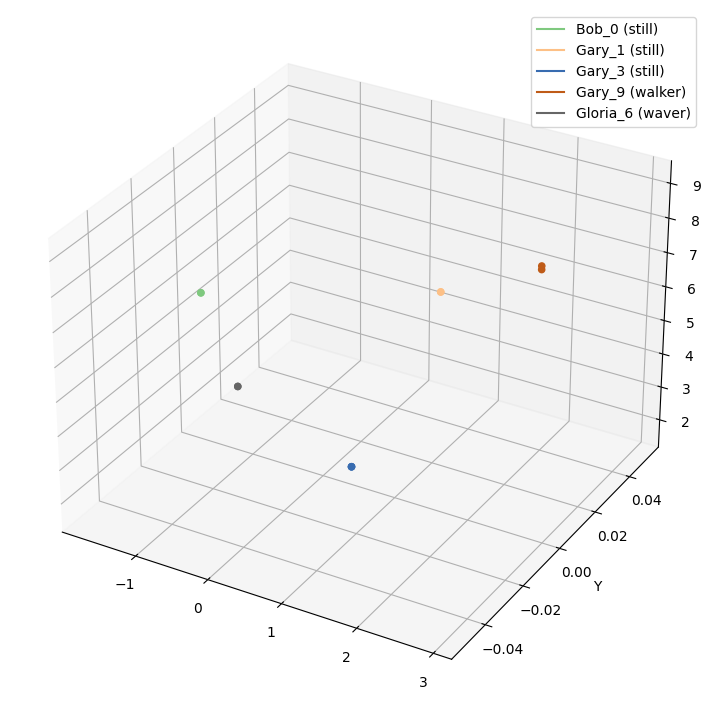

In [287]:

from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(18, 9)).add_subplot(projection='3d')
counter = 5
mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_id == random_time_group)
color_cycler = nu.get_color_cycler(min(counter, frvrs_logs_df[mask_series].groupby('patient_id').size().shape[0]))
location_cns_list = ['patient_record_position', 'patient_engaged_position']
for ((session_uuid, patient_id), patient_df), face_color_dict in zip(fu.get_session_groupby(
    frvrs_logs_df, mask_series=mask_series, extra_column='patient_id'
), color_cycler()):
    x = []; y = []; z = []
    for location_cn in location_cns_list:
        mask_series = patient_df[location_cn].isnull()
        srs = patient_df[~mask_series][location_cn].map(lambda x: eval(x))
        x.extend(srs.map(lambda x: x[0]).values)
        y.extend(srs.map(lambda x: x[1]).values)
        z.extend(srs.map(lambda x: x[2]).values)
    face_color = face_color_dict['color']
    label = patient_id.replace(' Root', ' (') + patient_df.patient_engaged_sort.dropna().tolist()[-1] + ')'
    ax.plot(x, y, z, c=face_color, alpha=1.0, label=label)
    ax.scatter(x, y, z, c=face_color, alpha=1.0)
    counter -= 1
    if counter <= 0:
        break

# Add labels
ax.legend()
ax.set_ylabel('Y');

In [205]:

# Get the session with the most teleports
mask_series = (frvrs_logs_df.action_type == 'TELEPORT')
session_uuid, scene_id = fu.get_session_groupby(
    frvrs_logs_df, mask_series=mask_series, extra_column='scene_id'
).size().sort_values().tail(1).index[0]

In [318]:

# Get a teleport distance relative to zero
mask_series = (frvrs_logs_df.action_type == 'TELEPORT')
mask_series &= (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id)
df = frvrs_logs_df[mask_series].sort_values(['event_time', 'action_tick']).dropna(axis='columns', how='all')
def f(second_point):
    x1, x2, y1, y2, z1, z2 = self.get_coordinates(second_point, first_point=None)
    euclidean_distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    
    return euclidean_distance
df['teleport_distance'] = df.teleport_location.map(f)
display(df)

,action_type,action_tick,event_time,session_uuid,file_name,teleport_location,scene_id,location_id,new_teleport_location,teleport_distance
128466,TELEPORT,3886,2023-05-09 09:59:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(1.9, 0.0, 1.2)",0,"(1.9, 0.0, 1.2)","(1.9, 0.0, 1.2)",2.247221
128467,TELEPORT,4386,2023-05-09 09:59:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(2.0, 0.0, 1.1)",0,"(2.0, 0.0, 1.1)",NaN,2.282542
128468,TELEPORT,5223,2023-05-09 09:59:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(2.0, 0.0, 0.9)",0,"(2.0, 0.0, 0.9)",NaN,2.193171
128469,TELEPORT,5508,2023-05-09 09:59:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(2.0, 0.0, 0.9)",0,"(2.0, 0.0, 0.9)",NaN,2.193171
128501,TELEPORT,22731,2023-05-09 10:00:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(0.8, 0.0, -3.4)",0,"(0.8, 0.0, -3.4)",NaN,3.492850
128502,TELEPORT,23438,2023-05-09 10:00:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(0.8, 0.0, -3.4)",0,"(0.8, 0.0, -3.4)",NaN,3.492850
128503,TELEPORT,24790,2023-05-09 10:00:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(2.1, 0.0, -4.0)",0,"(2.1, 0.0, -4.0)",NaN,4.517743
128504,TELEPORT,29428,2023-05-09 10:00:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(1.8, 0.0, 4.5)",0,"(1.8, 0.0, 4.5)",NaN,4.846648
128505,TELEPORT,31700,2023-05-09 10:00:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(3.1, 0.0, 3.9)",0,"(3.1, 0.0, 3.9)",NaN,4.981967
128506,TELEPORT,39168,2023-05-09 10:00:00,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,ff97fc56-c803-4aa7-b419-35e0ac17d0b3,"(4.9, 0.0, 2.7)",0,"(4.9, 0.0, 2.7)",NaN,5.594640


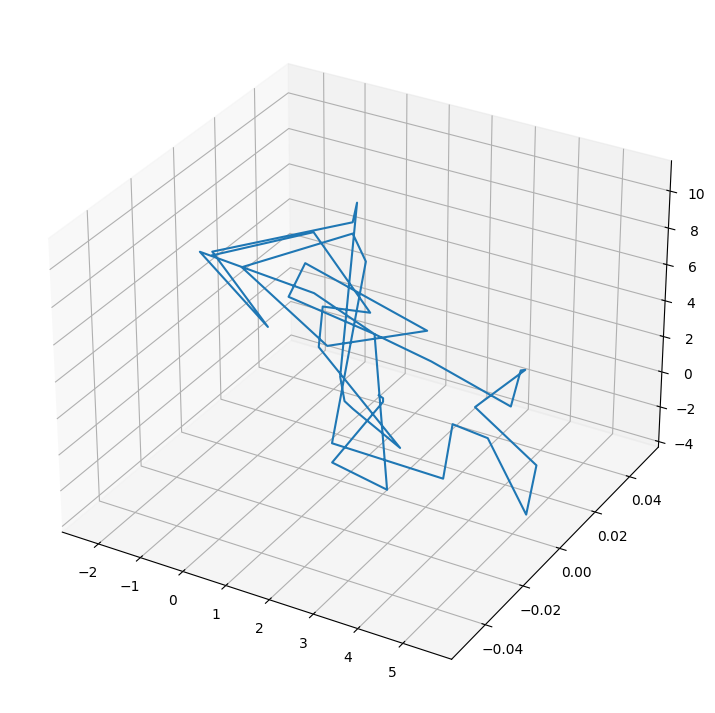

In [319]:

# Visualize non-cumulative teleportations
ax = plt.figure(figsize=(18, 9)).add_subplot(projection='3d')
x = []; y = []; z = []
for teleport_location in df.teleport_location:
    teleport_location = eval(teleport_location)
    x.append(teleport_location[0])
    y.append(teleport_location[1])
    z.append(teleport_location[2])
ax.plot(x, y, z, alpha=1.0);

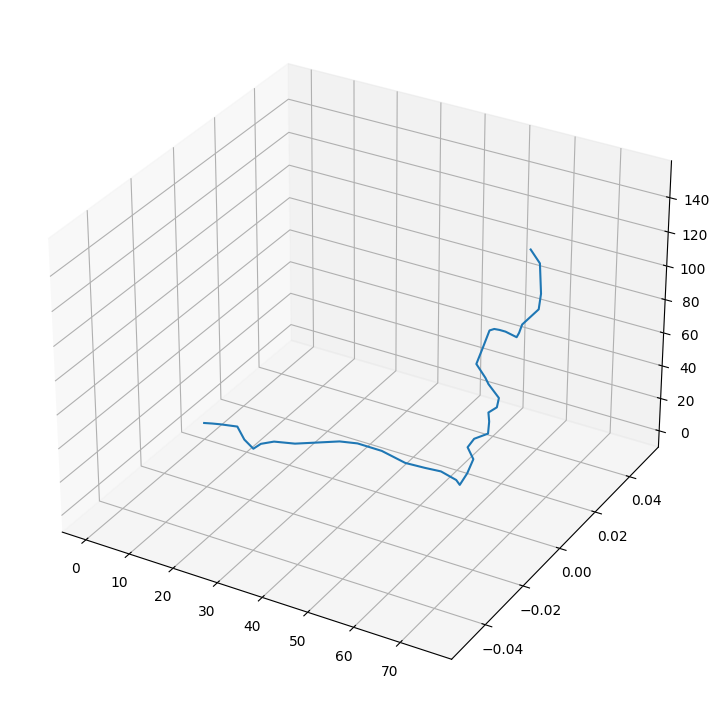

In [320]:

# Visualize cumulative teleportations
ax = plt.figure(figsize=(18, 9)).add_subplot(projection='3d')
x = [0.0]; y = [0.0]; z = [0.0]
old_teleport_location = (x[0], y[0], z[0])
for row_index, row_series in df.iterrows():
    teleport_location = row_series.teleport_location
    new_teleport_location = nu.get_absolute_position(teleport_location, first_point=str(old_teleport_location))
    df.loc[row_index, 'new_teleport_location'] = str(new_teleport_location)
    old_teleport_location = new_teleport_location
    x.append(new_teleport_location[0])
    y.append(new_teleport_location[1])
    z.append(new_teleport_location[2])
ax.plot(x, y, z, alpha=1.0);

In [321]:

# Add a new teleport location column to the main dataset
frvrs_logs_df = nu.load_object('frvrs_logs_df')
for session_uuid, df in fu.get_session_groupby(frvrs_logs_df, mask_series=None, extra_column=None):
    old_teleport_location = (0.0, 0.0, 0.0)
    mask_series = (df.action_type == 'TELEPORT')
    for row_indices_list in nu.split_row_indices_list(df[mask_series].index, teleport_indices_list):
        mask_series = df.index.isin(row_indices_list)
        df1 = df[mask_series]
        # print(df1.index[0]); display(df1.dropna(axis='columns', how='all')); raise
        teleport_location = df1.iloc[0].teleport_location
        if (pd.notnull(teleport_location)):
            row_index = df1.index[0]
            # print(row_index, row_indices_list, teleport_location); display(frvrs_logs_df.loc[row_index]); raise
            new_teleport_location = nu.get_absolute_position(teleport_location, first_point=str(old_teleport_location))
            frvrs_logs_df.loc[row_index, 'new_teleport_location'] = str(new_teleport_location)
            old_teleport_location = new_teleport_location

In [322]:

# Explore what types of columns we have
columns_list = ['teleport_location', 'new_teleport_location']
df = nu.get_column_descriptions(frvrs_logs_df, columns_list).sort_values('count_uniques')
mask_series = df.column_name.isin(columns_list)
df[mask_series].T

,1,0
column_name,new_teleport_location,teleport_location
dtype,object,object
count_blanks,149025,143488
count_uniques,32,3423
count_zeroes,0,0
has_dates,False,False
min_value,"(-0.1, 0.0, -2.7)","(-0.1, 0.0, -2.7)"
max_value,"(7.9, 0.0, 3.8)","(6.5, 0.0, 2.0)"
only_integers,NaN,NaN


In [323]:

mask_series = ~frvrs_logs_df.new_teleport_location.isnull() & ~frvrs_logs_df.teleport_location.isnull()
mask_series &= (frvrs_logs_df.new_teleport_location != frvrs_logs_df.teleport_location)
columns_list = ['session_uuid', 'action_tick', 'event_time', 'teleport_location', 'new_teleport_location']
frvrs_logs_df[mask_series][columns_list]

,session_uuid,action_tick,event_time,teleport_location,new_teleport_location
50802,04882754-51a0-4e5b-9617-b200e3609116,66309,2023-06-07 10:27:00,"(3.7, 0.0, 5.3)","(4.5, 0.0, 1.9)"
50826,04882754-51a0-4e5b-9617-b200e3609116,100778,2023-06-07 10:27:00,"(3.4, 0.0, 1.9)","(7.9, 0.0, 3.8)"
50855,04882754-51a0-4e5b-9617-b200e3609116,141854,2023-06-07 10:28:00,"(2.6, 0.0, -1.1)","(10.5, 0.0, 2.7)"
50856,04882754-51a0-4e5b-9617-b200e3609116,143393,2023-06-07 10:28:00,"(2.6, 0.0, -1.1)","(13.1, 0.0, 1.6)"
50969,04882754-51a0-4e5b-9617-b200e3609116,227522,2023-06-07 10:29:00,"(0.8, 0.0, -2.3)","(13.9, 0.0, -0.7)"
51237,04882754-51a0-4e5b-9617-b200e3609116,293998,2023-06-07 10:30:00,"(0.8, 0.0, 0.4)","(14.7, 0.0, -0.3)"
51267,04882754-51a0-4e5b-9617-b200e3609116,329283,2023-06-07 10:31:00,"(-1.3, 0.0, 4.0)","(13.4, 0.0, 3.7)"
51292,04882754-51a0-4e5b-9617-b200e3609116,366478,2023-06-07 10:32:00,"(0.2, 0.0, 7.2)","(13.6, 0.0, 10.9)"
51341,04882754-51a0-4e5b-9617-b200e3609116,396810,2023-06-07 10:32:00,"(1.9, 0.0, 4.8)","(15.5, 0.0, 15.7)"
51344,04882754-51a0-4e5b-9617-b200e3609116,401192,2023-06-07 10:32:00,"(0.0, 0.0, -1.2)","(15.5, 0.0, 14.5)"


In [328]:

teleport_mask_series = ~frvrs_logs_df.new_teleport_location.isnull()
for session_uuid, df in fu.get_session_groupby(frvrs_logs_df, mask_series=teleport_mask_series, extra_column=None):
    mask_series = (frvrs_logs_df.session_uuid == session_uuid)
    for row_indices_list in nu.split_row_indices_list(df.index, frvrs_logs_df[mask_series].index):
        base_mask_series = frvrs_logs_df.index.isin(row_indices_list)
        df1 = frvrs_logs_df[base_mask_series]
        new_teleport_location = df1.iloc[0].new_teleport_location
        if (str(new_teleport_location) == 'nan'):
            print(df1.index[0]); display(df1.dropna(axis='columns', how='all')); raise